In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import seaborn as sn

In [3]:
# from google.colab import drive (uncomment this if run from colab)
# drive.mount('/content/drive')

In [4]:
path = "./cifar-100-python/"

# Pre-Processing

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
# unloading datasets to train, test and meta (labels)
meta = unpickle(path + 'meta')
train = unpickle(path + 'train')
test = unpickle(path + 'test')

In [7]:
# gathering the list of labels
labels = list(meta[b'fine_label_names'])

## Splitting the dataset to train, test and validation for training

In [8]:
y_train = train[b'fine_labels']
y_test = test[b'fine_labels']
X_train = train[b'data'].reshape(50000, 3, 32, 32).transpose(0,2,3,1)
X_test = test[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)

In [9]:
y_train = to_categorical(y_train, len(labels)) # one hot encoding 
y_test = to_categorical(y_test, len(labels))

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = 1)

## Data augmentation

In [12]:
# from tutorial week 8
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range = 45, 
                                   width_shift_range = 0.15,  
                                   height_shift_range = 0.15)
train_datagen.fit(X_train)
test_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator =  train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = test_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)

# CNN Alex-Net based

## Defining the model

In [13]:
model = Sequential()
model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(11, 11), padding='same', strides=(4, 4), filters=96, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(kernel_size=(5, 5), padding='same', strides=(1, 1), filters=256, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


model.add(Conv2D(kernel_size=(3, 3), padding='same', strides=(1, 1), filters=384, activation = 'relu'))
model.add(Conv2D(kernel_size=(3, 3), padding='same', strides=(1, 1), filters=384, activation = 'relu'))
model.add(Conv2D(kernel_size=(1, 1), padding='same', strides=(1, 1), filters=256, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(units=y_train.shape[1], activation='softmax'))


model.summary()


opt = SGD(learning_rate = 0.02, momentum = 0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         8

## Fitting the model to training

In [14]:
history = model.fit(train_generator, 
    validation_data=val_generator, 
    batch_size = 32,
    epochs=100, 
    steps_per_epoch=len(train_generator),
    validation_steps= len(val_generator))

Epoch 1/100
1250/1250 [==============================] - 19s 11ms/step - loss: 4.4420 - accuracy: 0.0267 - val_loss: 4.2207 - val_accuracy: 0.0394
Epoch 2/100
1250/1250 [==============================] - 13s 11ms/step - loss: 4.1774 - accuracy: 0.0481 - val_loss: 4.1138 - val_accuracy: 0.0578
Epoch 3/100
1250/1250 [==============================] - 13s 10ms/step - loss: 4.0538 - accuracy: 0.0644 - val_loss: 3.9140 - val_accuracy: 0.0807
Epoch 4/100
1250/1250 [==============================] - 13s 11ms/step - loss: 3.9700 - accuracy: 0.0782 - val_loss: 3.8313 - val_accuracy: 0.0978
Epoch 5/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.9005 - accuracy: 0.0898 - val_loss: 3.8834 - val_accuracy: 0.0978
Epoch 6/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.8600 - accuracy: 0.0972 - val_loss: 3.7897 - val_accuracy: 0.0972
Epoch 7/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.8162 - accuracy: 0.1027 - val_loss: 3

In [15]:
# model.save("alexnet_100.h5")

In [16]:
# reloaded_model = keras.models.load_model("alexnet_100.h5",compile=True)

## Running the trained model on test set

In [17]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 3.2924792766571045 / Test accuracy: 0.2142000049352646


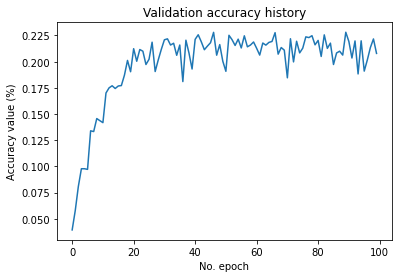

In [18]:
#Plot of Validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

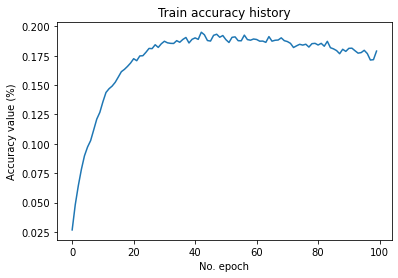

In [19]:
# plot of train accuracy
plt.plot(history.history['accuracy'])
plt.title('Train accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

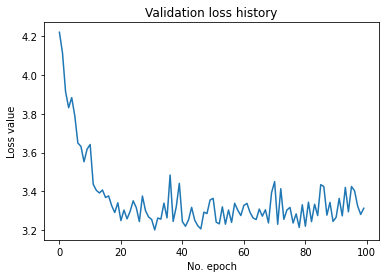

In [20]:
# plot of validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

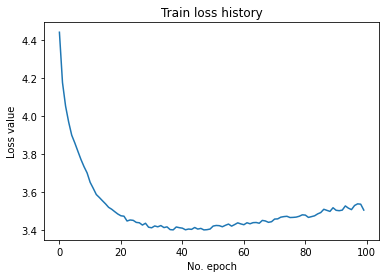

In [21]:
# plot of trian loss
plt.plot(history.history['loss'])
plt.title('Train loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

Text(0.5, 1.0, "b'fox'")

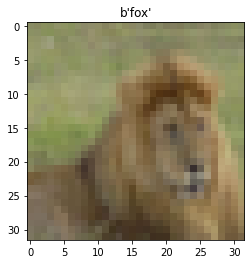

In [22]:
# printing example of predicted lable and actual image
test_index = 15

img = X_test[test_index]
plt.imshow(img)
plt.title(labels[np.argmax(model.predict(img.reshape(1,32,32,3)))])

In [23]:
Y_pred = model.predict(X_test)

In [25]:
# results
pred=np.argmax(Y_pred,axis=1)
ground = np.argmax(y_test,axis=1)
print(classification_report(ground,pred))
print(accuracy_score(ground, pred))

              precision    recall  f1-score   support

           0       0.44      0.31      0.36       100
           1       0.33      0.22      0.26       100
           2       0.11      0.26      0.16       100
           3       0.13      0.03      0.05       100
           4       0.11      0.03      0.05       100
           5       0.08      0.07      0.07       100
           6       0.36      0.18      0.24       100
           7       0.19      0.30      0.23       100
           8       0.15      0.32      0.21       100
           9       0.33      0.15      0.21       100
          10       0.00      0.00      0.00       100
          11       0.25      0.01      0.02       100
          12       0.34      0.17      0.23       100
          13       0.13      0.58      0.22       100
          14       0.11      0.03      0.05       100
          15       0.10      0.21      0.13       100
          16       0.15      0.03      0.05       100
          17       0.36    

C:\Users\Ananda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ananda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ananda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

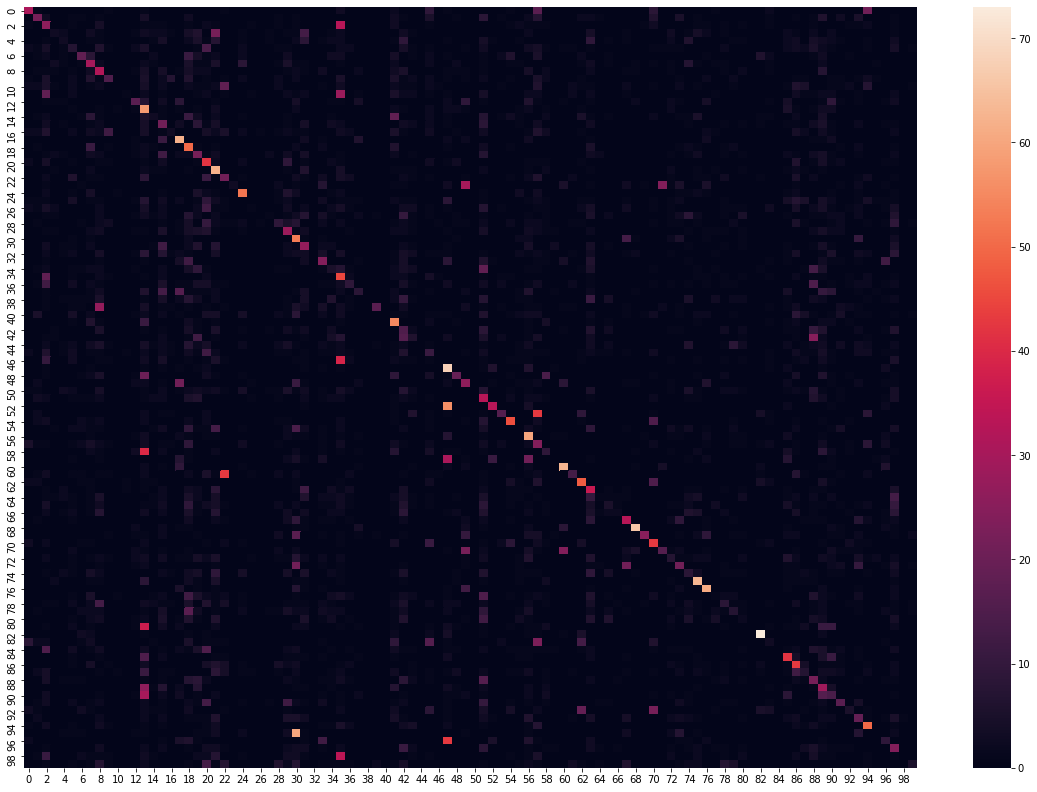

In [28]:
#confusion matrix
plt.figure(figsize = (20,14))
sn.heatmap(confusion_matrix(ground, pred))